In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling, Resizing
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
from pylab import rcParams

print(python_version())
print(tf.__version__)

3.7.12
2.7.0


In [2]:
rcParams['figure.figsize'] = (10, 6)

In [3]:
tfds.disable_progress_bar()

(train_ds, val_ds, test_ds), info = tfds.load(
                                    'rock_paper_scissors',
                                     split=('train[:80%]', 'train[80%:90%]', 'train[90%:]'),
                                     with_info=True,
                                     as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteA8SZ2M/rock_paper_scissors-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteA8SZ2M/rock_paper_scissors-test.tfrecord
Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [5]:
training_images = info.splits['train[:80%]'].num_examples
validation_images = info.splits['train[80%:90%]'].num_examples
test_images = info.splits['train[90%:]'].num_examples
print(f'Training Images: {training_images}')
print(f'Validation Images: {validation_images}')
print(f'Test Images: {test_images}')

Training Images: 2016
Validation Images: 252
Test Images: 252


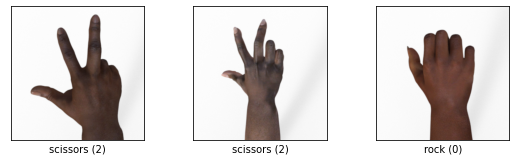

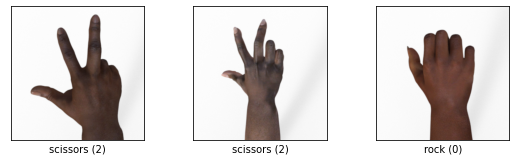

In [6]:
tfds.show_examples(train_ds.take(3), info)    

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 64

def configure_dataset(dataset, shuffle=False):
  if shuffle:
    dataset = dataset.cache()\
                     .shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)\
                     .batch(BATCH_SIZE, drop_remainder=True)\
                     .prefetch(AUTOTUNE)
  else:
      dataset = dataset.cache()\
                       .batch(BATCH_SIZE, drop_remainder=True)\
                       .prefetch(AUTOTUNE)
  return dataset

In [8]:
train_ds = configure_dataset(train_ds, shuffle=True)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds)

In [9]:
IMG_HEIGHT = 150
IMG_WIDTH = 150

image_augmentation = Sequential([
                                  RandomFlip('horizontal_and_vertical'),
                                  RandomRotation(0.3),
                                  RandomZoom(0.1)
])

rescale_layer = Rescaling(scale=1./255)
resize_layer = Resizing(height=IMG_HEIGHT, width=IMG_WIDTH)

In [10]:
model = Sequential([
                    layers.InputLayer(input_shape=[300, 300, 3]),
                    resize_layer,
                    rescale_layer,
                    image_augmentation,
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(128, (3, 3), activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                      

In [11]:
EPOCHS=30

model.compile(
              loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy']
)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/30
31/31 [==============================] - 19s 114ms/step - loss: 1.2067 - accuracy: 0.4022 - val_loss: 1.0153 - val_accuracy: 0.4688
Epoch 2/30
31/31 [==============================] - 2s 62ms/step - loss: 0.8803 - accuracy: 0.6013 - val_loss: 0.6697 - val_accuracy: 0.6927
Epoch 3/30
31/31 [==============================] - 2s 60ms/step - loss: 0.6027 - accuracy: 0.7394 - val_loss: 0.6140 - val_accuracy: 0.7812
Epoch 4/30
31/31 [==============================] - 2s 61ms/step - loss: 0.4559 - accuracy: 0.8221 - val_loss: 0.3776 - val_accuracy: 0.8438
Epoch 5/30
31/31 [==============================] - 2s 61ms/step - loss: 0.3702 - accuracy: 0.8579 - val_loss: 0.3194 - val_accuracy: 0.8750
Epoch 6/30
31/31 [==============================] - 2s 69ms/step - loss: 0.3021 - accuracy: 0.8821 - val_loss: 0.2563 - val_accuracy: 0.8698
Epoch 7/30
31/31 [==============================] - 2s 61ms/step - loss: 0.2498 - accuracy: 0.9062 - val_loss: 0.2044 - val_accuracy: 0.9375
Epoch 8/30


In [12]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 130ms/step - loss: 0.0062 - accuracy: 1.0000


[0.006151521112769842, 1.0]

In [13]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [14]:
def plot_history(train_history, val_history, label):
  plt.plot(train_history, label=f'Training {label}')
  plt.plot(val_history, label=f'Validation {label}')
  plt.ylabel(f'{label}')
  plt.xlabel('Epochs')
  plt.legend()
  return plt.show()

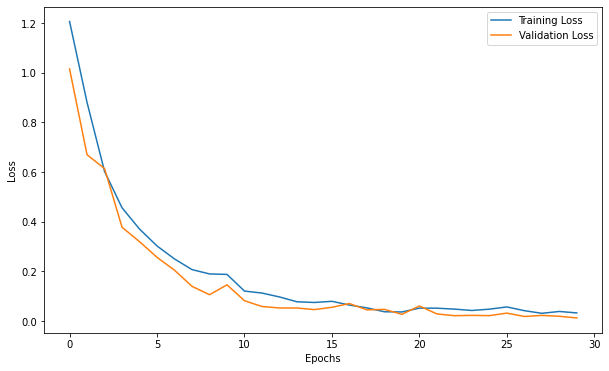

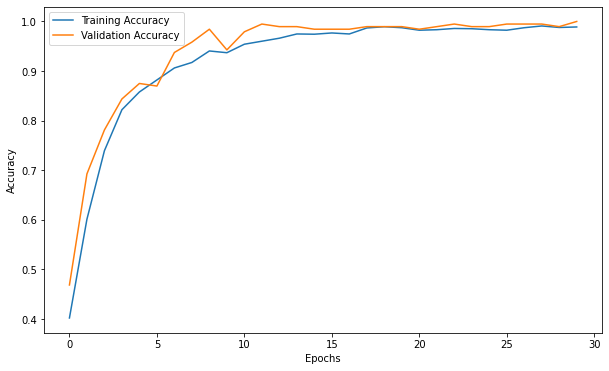

In [15]:
plot_history(train_loss, val_loss, 'Loss')
plot_history(train_acc, val_acc, 'Accuracy')